In [1]:
import numpy as np

NUM_WARMUP = 2000
NUM_SAMPLES = 1000
NUM_CHAINS = 8

In [2]:
import os

n_devices = min(os.cpu_count(), NUM_CHAINS)
os.environ['XLA_FLAGS'] = f'--xla_force_host_platform_device_count={n_devices}'

from jax import random
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
import seaborn as sns

import numpyro
import numpyro.distributions as dist
from numpyro.handlers import reparam
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.infer.reparam import LocScaleReparam

In [75]:
def nn_funnel_super_narrow(X, y=None):
    X = jnp.expand_dims(X, axis=-1)

    tau_w = numpyro.sample("tau_w", dist.Exponential(4.5))
    tau_b = numpyro.sample("tau_b", dist.Exponential(4.5))
    # 3) tiny multiplier + power‐law
    c = 0.4
    p = 2.0

    num_neurons = 2
    W = numpyro.sample(
        "W",
        dist.Normal(0.0, c* (tau_w ** p)).expand([num_neurons]),
        # dist.Normal(0.0, c*tau_w).expand([2])
    )
    W = jnp.reshape(W, (num_neurons, 1))
    B = numpyro.sample(
        "B",
        dist.Normal(0.0,  c*(tau_b ** p)).expand([num_neurons])
        # dist.Normal(0.0, c* tau_b).expand([2])
    )
    z = jnp.matmul(X, W.T) + B
    mu = z[..., 0]
    log_sigma = z[..., 1]
    sigma_y = jnp.exp(
        log_sigma
    )
    print(mu.shape, sigma_y.shape)
    numpyro.sample("obs", dist.Normal(mu, sigma_y), obs=y)

# non-centered reparam just on the weight scale "W"
reparam_model = reparam(
    nn_funnel_super_narrow,
    config={
      "W": LocScaleReparam(0),
      "B": LocScaleReparam(0)
    }   # decouples W, B from tau_w
)


def run_inference(model, X, y, rng_key):
    kernel = NUTS(
        model,
        target_accept_prob=0.80,
        max_tree_depth=20,
    )
    mcmc = MCMC(
        kernel,
        num_warmup=NUM_WARMUP,
        num_samples=NUM_SAMPLES,
        num_chains=NUM_CHAINS,
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    mcmc.run(rng_key, X, y)
    mcmc.print_summary(exclude_deterministic=False)
    return mcmc

In [76]:
# ─ simulate some toy data ────────────────────────────────────────────────
rng_key = random.PRNGKey(42)
N = 1000
X = jnp.linspace(-1, 1, N)
true_mu, true_sigma = 1.5, 0.5 #,  X**2 + np.sin(4*X), 0.1 + np.exp(X)/10  #1.5, 0.5
y = random.normal(rng_key, (N,)) * true_sigma + true_mu

# X = (X - jnp.mean(X)) / jnp.std(X)
# y = (y - jnp.mean(y)) / jnp.std(y)

# ─ centered parameterization ─────────────────────────────────────────────
print("===== Centered parameterization =====")
mcmc_c = run_inference(nn_funnel_super_narrow, X, y, rng_key)
samples_c = mcmc_c.get_samples()
div_c     = mcmc_c.get_extra_fields()["diverging"]


# ─ non-centered parameterization ─────────────────────────────────────────
print("\n===== Non-centered parameterization =====")
mcmc_nc = run_inference(reparam_model, X, y, rng_key)
samples_nc = mcmc_nc.get_samples()
div_nc     = mcmc_nc.get_extra_fields()["diverging"]

===== Centered parameterization =====
(1000,) (1000,)
(1000,) (1000,)


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

(1000,) (1000,)

                mean       std    median      5.0%     95.0%     n_eff     r_hat
      B[0]      1.48      0.02      1.48      1.45      1.51     31.07      1.18
      B[1]     -0.67      0.02     -0.67     -0.71     -0.64   1990.45      1.01
      W[0]      0.00      0.01     -0.00     -0.02      0.02   3804.16      1.00
      W[1]     -0.00      0.01     -0.00     -0.02      0.02   2772.37      1.00
     tau_b      1.44      0.22      1.43      1.09      1.75   2388.23      1.00
     tau_w      0.15      0.10      0.13      0.03      0.28    138.74      1.06

Number of divergences: 753

===== Non-centered parameterization =====
(1000,) (1000,)
(1000,) (1000,)


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

(1000,) (1000,)
(1000,) (1000,)

                     mean       std    median      5.0%     95.0%     n_eff     r_hat
           B[0]      1.48      0.02      1.48      1.46      1.51   8471.14      1.00
           B[1]     -0.67      0.02     -0.67     -0.71     -0.64   8286.66      1.00
B_decentered[0]      1.91      0.57      1.88      0.93      2.75   1268.91      1.00
B_decentered[1]     -0.86      0.26     -0.85     -1.27     -0.44   1271.48      1.00
           W[0]      0.00      0.01      0.00     -0.01      0.02   5595.81      1.00
           W[1]     -0.00      0.01     -0.00     -0.02      0.02   5069.98      1.00
W_decentered[0]      0.01      0.93      0.03     -1.59      1.47   4149.47      1.00
W_decentered[1]     -0.07      0.95     -0.07     -1.60      1.53   4742.73      1.00
          tau_b      1.45      0.24      1.41      1.07      1.79    962.55      1.01
          tau_w      0.13      0.10      0.10      0.00      0.27   4170.17      1.00

Number of divergence

In [77]:
(
    W_c, B_c,
    tau_w_c, tau_b_c
) = (
    samples_c["W"], samples_c["B"],  # [n_samples, 2]
    samples_c["tau_w"], samples_c["tau_b"]  # [n_samples]
)

(
    W_nc, B_nc,
    tau_w_nc, tau_b_nc
) = (
    samples_nc["W"], samples_nc["B"],  # [n_samples, 2]
    samples_nc["tau_w"], samples_nc["tau_b"]  # [n_samples]
)

C:\Users\Aleks Lyubenov\AppData\Local\Temp\ipykernel_23424\3064926623.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


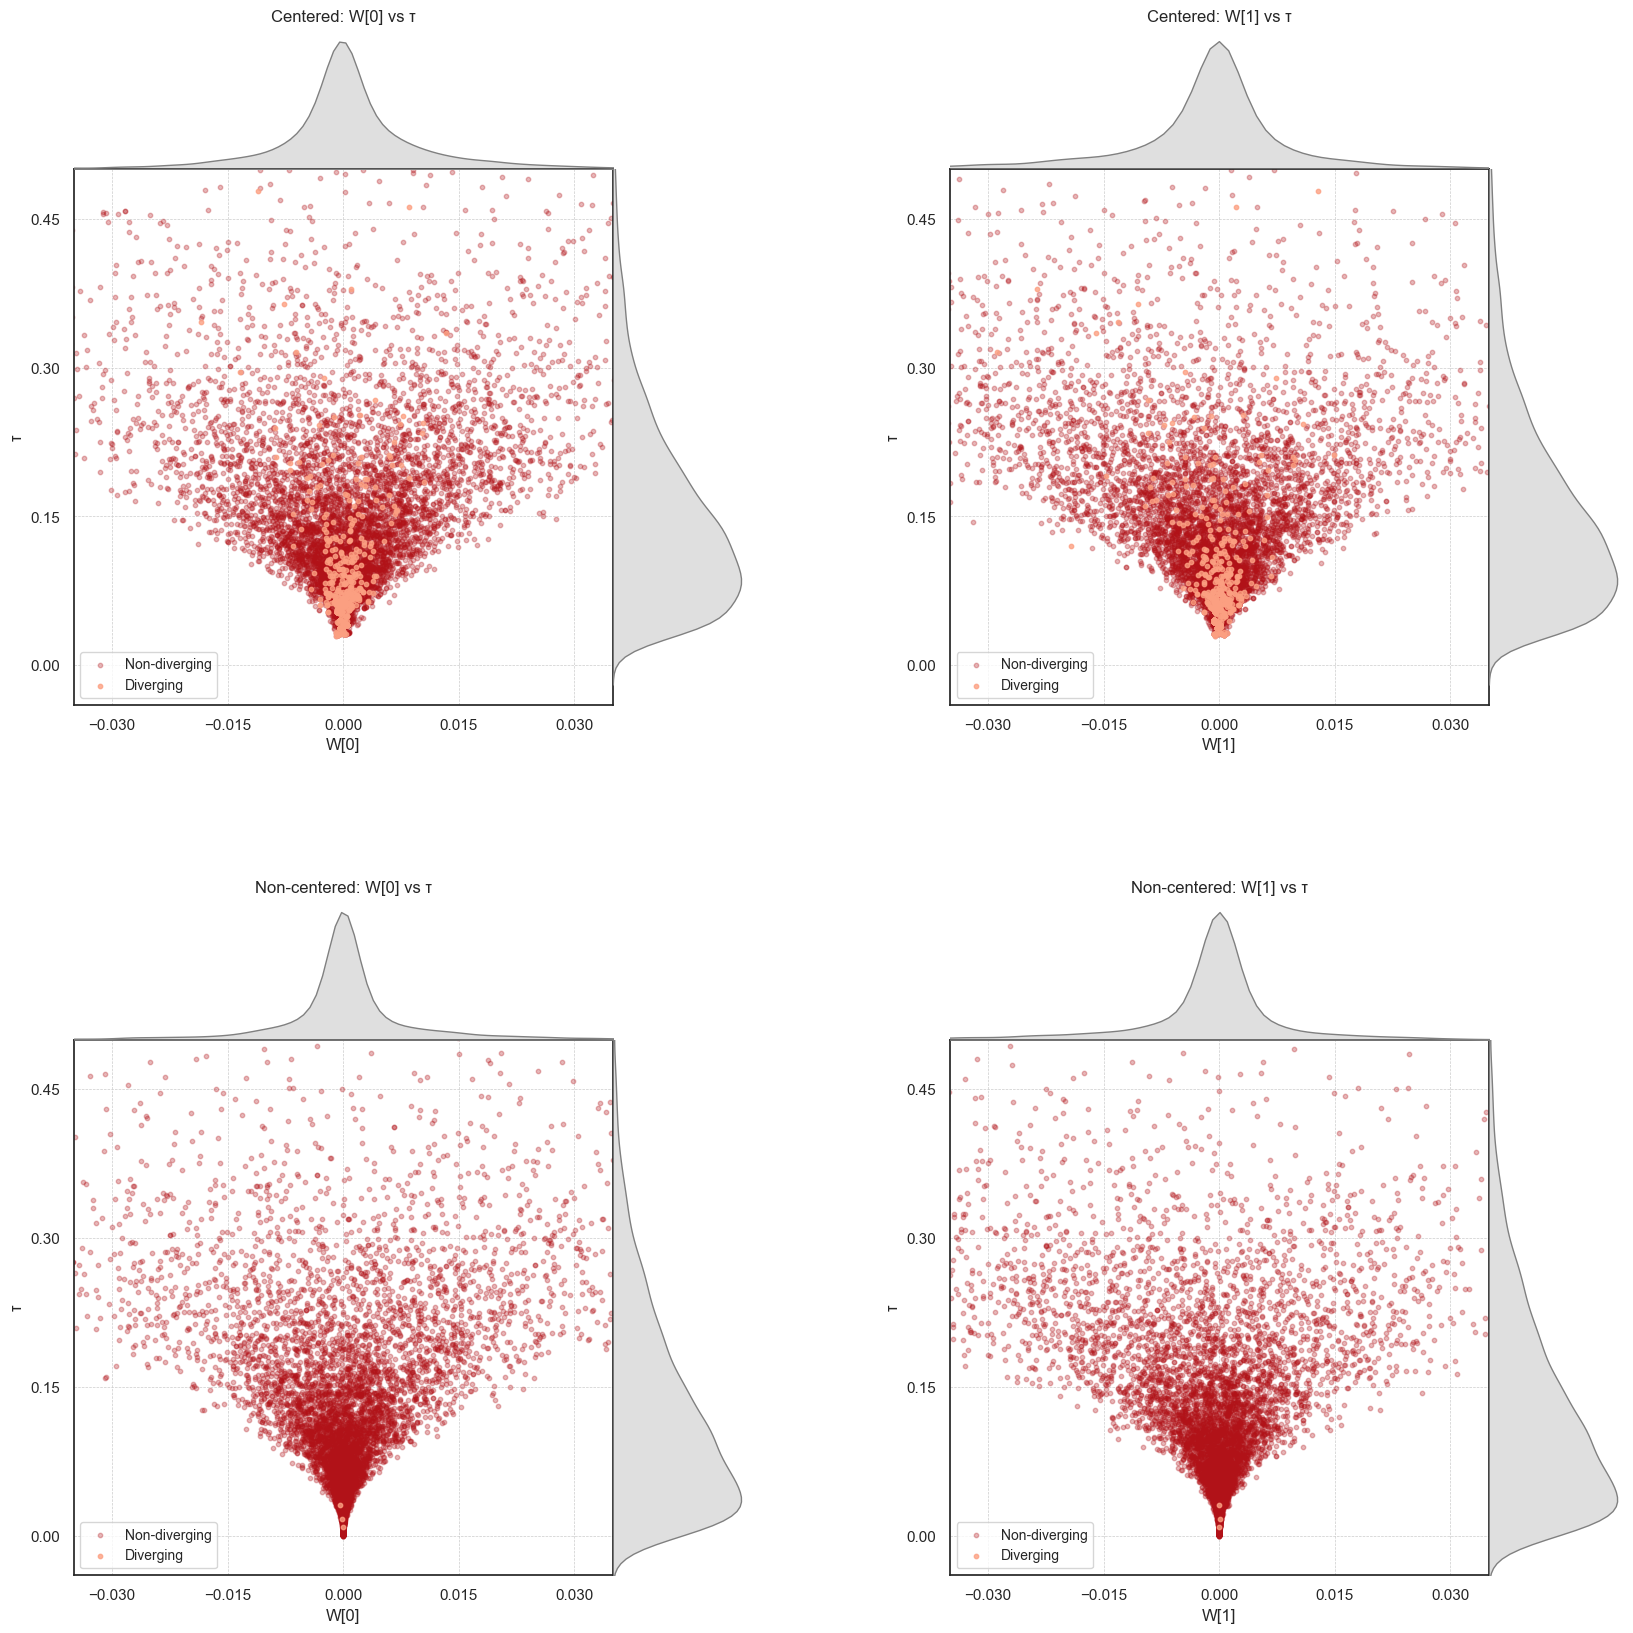

Centered divergences per chain: [ 39 399  62  59  80  57  12  45]
Non-centered divergences per chain: [0 0 1 1 1 0 0 0]


In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MaxNLocator

# 1) Clean white background
sns.set_style("white")

# 2) Grab two distinct, colorblind‐friendly colors
reds = sns.color_palette("Reds", n_colors=5)
col_nd =  reds[-1]   # lighter red
col_div = reds[-4]   # deepest red

fig = plt.figure(figsize=(20,20), constrained_layout=False)
outer_gs = GridSpec(2, 2, figure=fig, wspace=0.3, hspace=0.3)

panels = {
    (0,0): (W_c[:,0], tau_w_c, div_c, "Centered: W[0] vs τ"),
    (0,1): (W_c[:,1], tau_w_c, div_c, "Centered: W[1] vs τ"),
    (1,0): (W_nc[:,0], tau_w_nc, div_nc, "Non-centered: W[0] vs τ"),
    (1,1): (W_nc[:,1], tau_w_nc, div_nc, "Non-centered: W[1] vs τ"),
}

for (i, j), (W, tau, div, title) in panels.items():
    inner = outer_gs[i, j].subgridspec(
        2, 2,
        width_ratios=[4,1],
        height_ratios=[1,4],
        wspace=0.0,
        hspace=0.0,
    )

    # 1) Joint scatter (bottom-left)
    ax_joint = fig.add_subplot(inner[1, 0])
    ax_joint.scatter(
        W[~div], tau[~div],
        color=col_nd, alpha=0.3, s=10, label="Non-diverging"
    )
    ax_joint.scatter(
        W[ div], tau[ div],
        color=col_div, alpha=0.8, s=10, label="Diverging"
    )
    ax_joint.set(
        xlabel=title.split(":")[1].split(" vs")[0].strip(),
        ylabel="τ"
    )
    ax_joint.grid(True, lw=0.5, ls="--")
    ax_joint.legend(loc="lower left", fontsize="small")
    ax_joint.xaxis.set_major_locator(MaxNLocator(nbins=5))
    ax_joint.yaxis.set_major_locator(MaxNLocator(nbins=5))
    ax_joint.set_xlim(-0.035, 0.035)
    ax_joint.set_ylim(-0.04, 0.5)

    # 2) Top marginal (shares x with joint)
    ax_marg_x = fig.add_subplot(inner[0, 0], sharex=ax_joint)
    sns.kdeplot(x=W, ax=ax_marg_x, color="gray", fill=True)
    ax_marg_x.set_title(title, pad=10)
    ax_marg_x.axis("off")

    # 3) Right marginal (shares y with joint)
    ax_marg_y = fig.add_subplot(inner[1, 1], sharey=ax_joint)
    sns.kdeplot(y=tau, ax=ax_marg_y, color="gray", fill=True)
    ax_marg_y.axis("off")

plt.tight_layout()
# save
plt.savefig("nn_funnel_super_narrow.png", bbox_inches="tight")
plt.show()

print("Centered divergences per chain:",
      mcmc_c.get_extra_fields()["diverging"]
             .reshape(NUM_CHAINS, -1).sum(axis=1))
print("Non-centered divergences per chain:",
      mcmc_nc.get_extra_fields()["diverging"]
             .reshape(NUM_CHAINS, -1).sum(axis=1))
